In [1]:
import pandas as pd
import numpy as np
import os

import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [2]:
data_path = './data/train'
train_df = pd.read_csv(os.path.join(data_path, 'train_ratings.csv')) # 전체 학습 데이터

In [3]:
train_df.info()
train_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5154471 entries, 0 to 5154470
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   user    int64
 1   item    int64
 2   time    int64
dtypes: int64(3)
memory usage: 118.0 MB


,user,item,time
0,11,4643,1230782529
1,11,170,1230782534
2,11,531,1230782539
3,11,616,1230782542
4,11,2140,1230782563


영차

In [4]:
train_df.groupby(['user']).count()

,item,time
user,,
11,376,376
14,180,180
18,77,77
25,91,91
31,154,154
...,...,...
138473,63,63
138475,124,124
138486,137,137


In [5]:
train_df.groupby(['item']).count()

,user,time
item,,
1,12217,12217
2,3364,3364
3,734,734
4,43,43
5,590,590
...,...,...
118700,54,54
118900,60,60
118997,52,52


In [6]:
year_data = pd.read_csv(os.path.join(data_path, 'years.tsv'), sep='\t')
writer_data = pd.read_csv(os.path.join(data_path, 'writers.tsv'), sep='\t')
title_data = pd.read_csv(os.path.join(data_path, 'titles.tsv'), sep='\t')
genre_data = pd.read_csv(os.path.join(data_path, 'genres.tsv'), sep='\t')
director_data = pd.read_csv(os.path.join(data_path, 'directors.tsv'), sep='\t')

# EDA

전체 영화 소비량

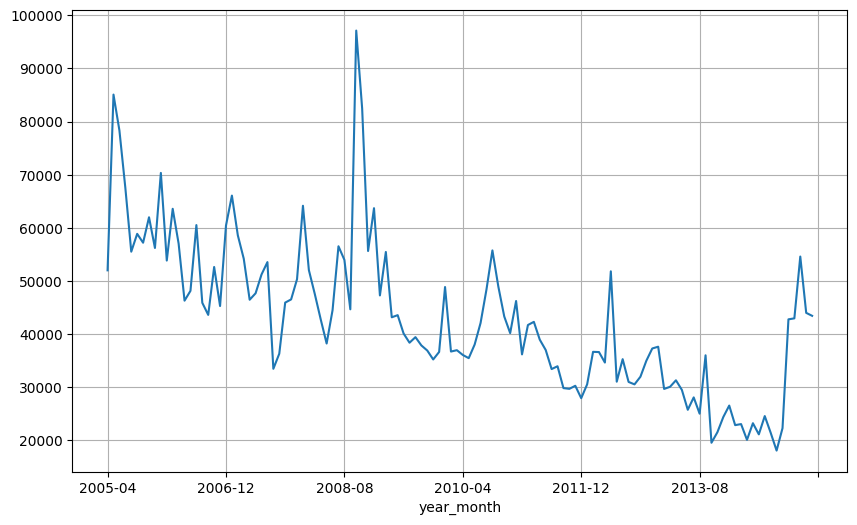

In [28]:
train_df['year_month'] = train_df['time'].apply(lambda x: time.strftime('%Y-%m', time.localtime(x)))
train_df['year_month'].value_counts().sort_index().plot(kind='line', figsize=(10,6))

plt.grid(True)
plt.show()

사용자가 시청할 때랑 영황 개봉 시간 비교

->영화를 개봉한 시점에 rating을 한 경우가 가장 많다. 하지만 꼬리가 길어보이지 않는다.

->그리고 당연히 옛날 영화는 얼마 없기 때문에 그래프 잘못 그린 듯

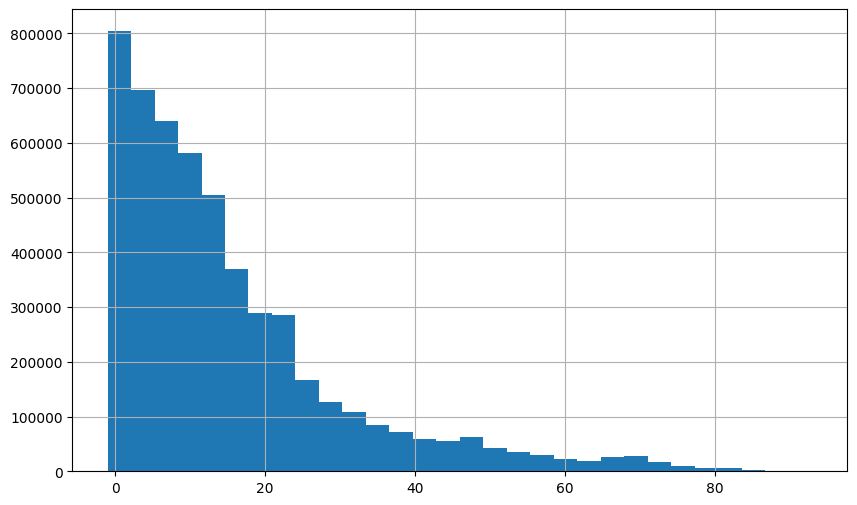

In [29]:
year_df['consumption_year'] = year_df['time'].apply(lambda x: int(time.strftime('%Y', time.localtime(x))))
year_df['year_diff'] = year_df['consumption_year'] - year_df['year']

year_df['year_diff'].hist(bins=30, figsize=(10,6))
plt.grid(True)
plt.show()

비슷한 취향을 가진 소비자 클러스터링

In [34]:
genre_df = pd.merge(train_df, genre_data, on='item')

In [35]:
user_genre_pivot = genre_df.pivot_table(index='user', columns='genre', aggfunc='size', fill_value=0)

In [39]:
user_genre_pivot

genre,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,pca1,pca2,cluster
user,,,,,,,,,,,,,,,,,,,,,
11,167,133,50,53,99,33,5,112,67,2,...,11,25,44,176,130,12,1,6.398014,3.954407,0
14,23,58,40,57,106,9,0,66,34,0,...,22,6,55,23,10,5,4,1.081846,3.713428,0
18,3,3,1,1,28,20,1,62,3,1,...,2,7,25,2,9,9,4,-2.312191,-0.908810,1
25,22,21,5,9,40,21,0,41,14,0,...,2,5,17,8,16,5,1,-1.991534,0.192021,1
31,92,94,32,44,49,12,2,24,47,0,...,0,9,10,49,36,5,6,0.992189,2.796513,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138473,15,12,9,6,6,20,0,37,14,3,...,2,15,8,9,25,1,1,-2.050627,-0.195761,1
138475,4,8,3,2,26,34,9,76,1,32,...,1,17,27,4,30,12,2,-0.305112,-4.239009,1
138486,47,39,11,18,53,11,0,34,28,0,...,6,9,11,32,60,3,1,-0.110392,1.109425,2


In [36]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(user_genre_pivot)

In [37]:
kmeans = KMeans(n_clusters=5, random_state=42)
user_clusters = kmeans.fit_predict(scaled_data)

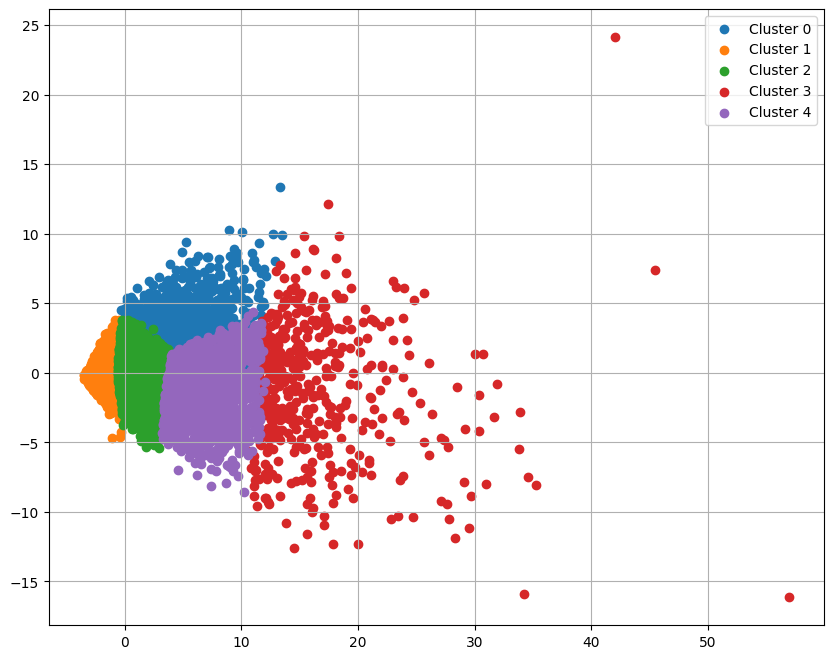

In [38]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

user_genre_pivot['pca1'] = pca_result[:, 0]
user_genre_pivot['pca2'] = pca_result[:, 1]
user_genre_pivot['cluster'] = user_clusters

plt.figure(figsize=(10, 8))
for cluster in range(5):
    cluster_data = user_genre_pivot[user_genre_pivot['cluster'] == cluster]
    plt.scatter(cluster_data['pca1'], cluster_data['pca2'], label=f'Cluster {cluster}')

plt.legend()
plt.grid(True)
plt.show()

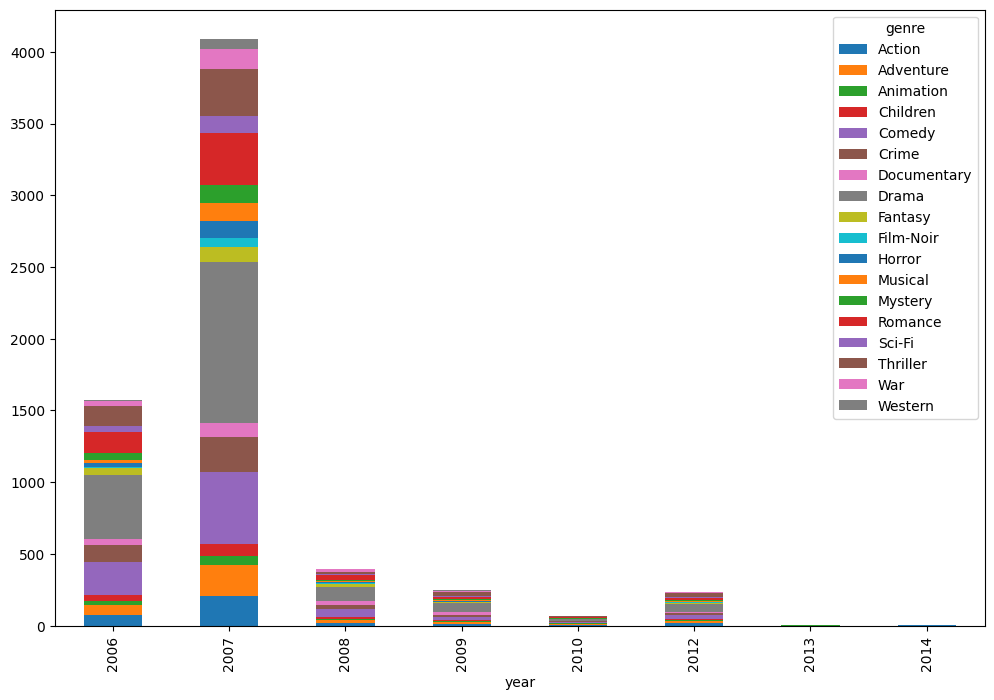

In [30]:

user_id = active_user_ids[0]

user_genre_time = genre_top[genre_top['user'] == user_id].copy()

user_genre_time['year'] = user_genre_time['time'].apply(lambda x: int(time.strftime('%Y', time.localtime(x))))

user_genre_time.groupby(['year', 'genre']).size().unstack().plot(kind='bar', stacked=True, figsize=(12,8))
plt.show()

상위 10명 유저들의 장르 선호도가 비슷

-> 그냥 영화 분포 자체가 저런가


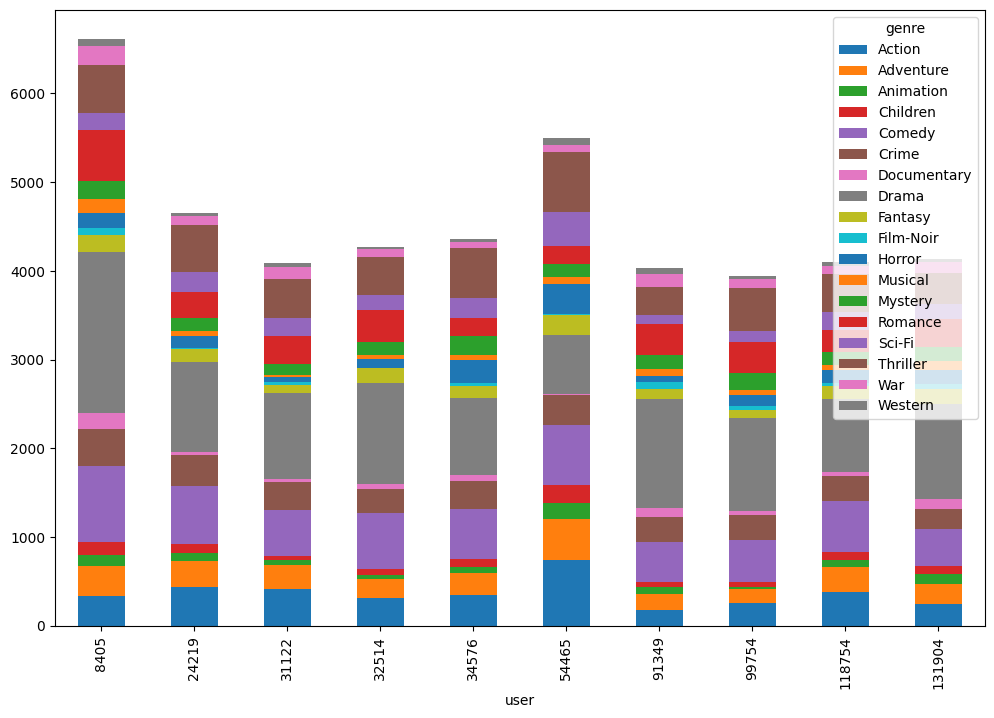

In [31]:
top_users = train_df['user'].value_counts().head(10).index

top_user_data = genre_df[genre_df['user'].isin(top_users)]
top_user_genre_counts = top_user_data.groupby('user')['genre'].value_counts().unstack().fillna(0)

# 시각화
top_user_genre_counts.plot(kind='bar', stacked=True, figsize=(12,8))

plt.show()

인기 영화 장르 분포

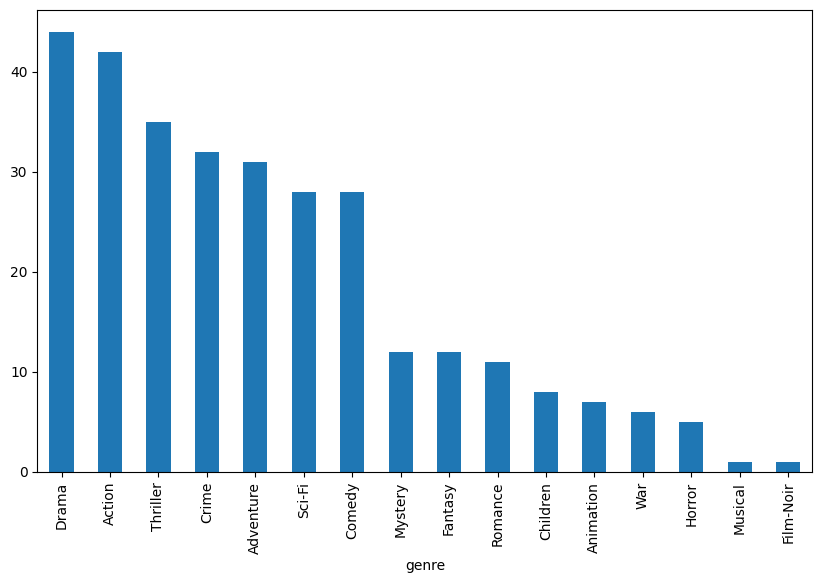

In [32]:
genre_df = pd.merge(train_df[['item']], genre_data, on='item').drop_duplicates()
popular_movie_ids = train_df['item'].value_counts().index[:100]
popular_genres = genre_df[genre_df['item'].isin(popular_movie_ids)]['genre'].value_counts()

plt.figure(figsize=(10,6))
popular_genres.plot(kind='bar')

plt.show()

상위 활동 사용자는 상위 영화를 많이 시청했을 것이다.

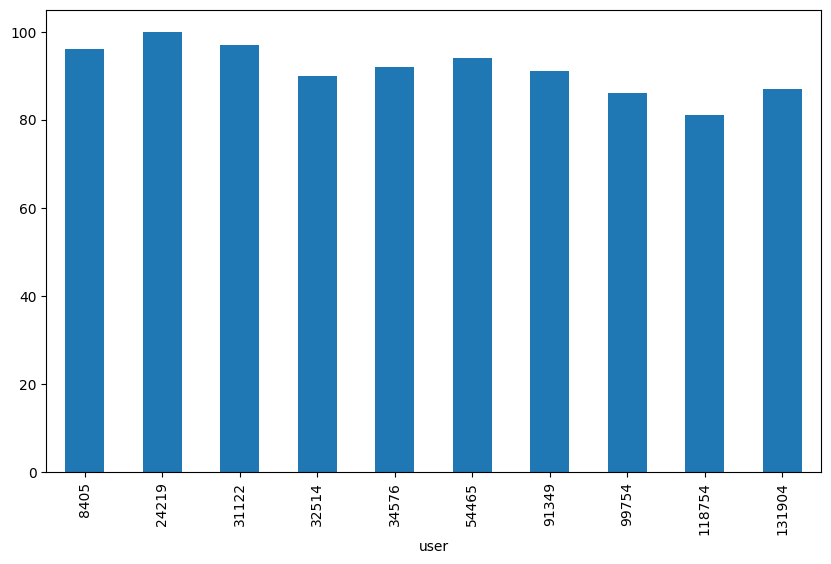

In [41]:
active_user_ids = train_df['user'].value_counts().index[:10]
active_user_popular_movies = train_df[(train_df['user'].isin(active_user_ids)) & (train_df['item'].isin(popular_movie_ids))]
user_popularity = active_user_popular_movies.groupby('user')['item'].count()

plt.figure(figsize=(10,6))
user_popularity.plot(kind='bar')

plt.show()

# 11/18 피어세션 이후 추가 EDA

### 1. 주은 언니의 EDA

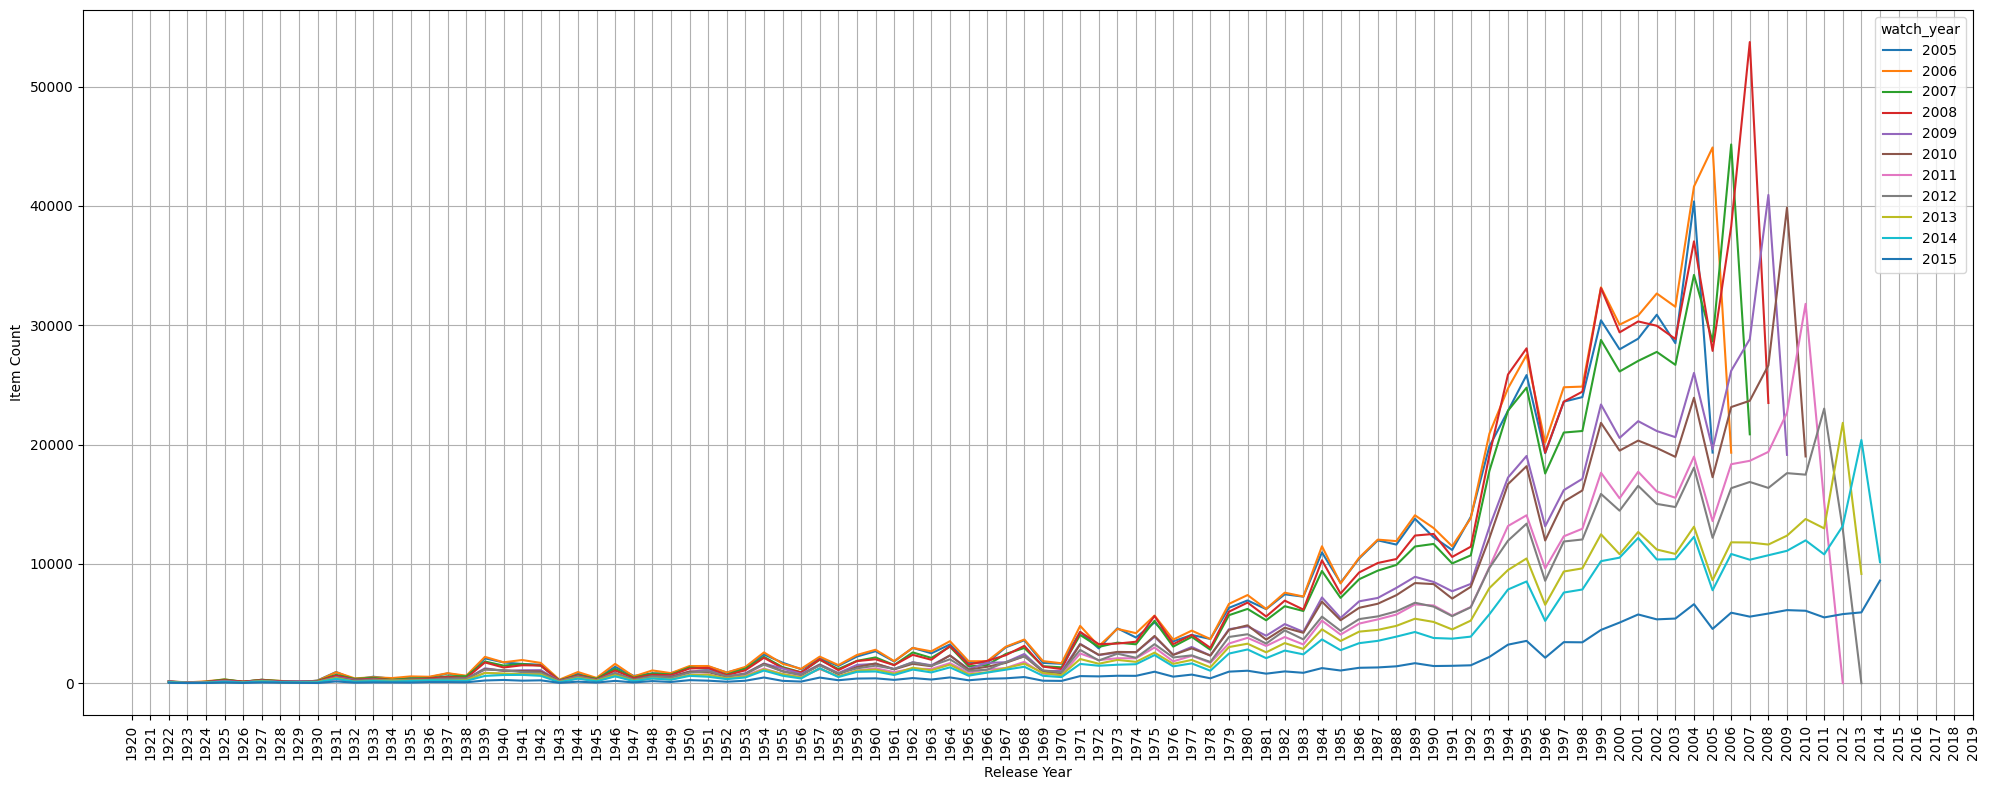

In [28]:
merged_df = pd.merge(train_df, year_data, on='item', how='left')

merged_df['watch_year'] = pd.to_datetime(merged_df['time'], unit='s').dt.year

watch_counts_by_year = merged_df.groupby(['year', 'watch_year']).size().reset_index(name='watch_count')

watch_counts_filtered = watch_counts_by_year[(watch_counts_by_year['watch_year'] >= 2005) & 
                                              (watch_counts_by_year['watch_year'] <= 2015)]

plt.figure(figsize=(20, 8))

sns.lineplot(x='year', y='watch_count', hue='watch_year', data=watch_counts_filtered, palette='tab10')

plt.xlabel('Release Year')
plt.ylabel('Item Count')
plt.xticks(range(1920, 2020, 1), rotation=90)
plt.grid(True)


plt.tight_layout()
plt.show()

영화가 release된 연도는 1920~2014이고, 영화를 rating을 한 연도는 2005~2015이다.

따라서 각 그래프는 20nn년에 rating 수를 그린 것이고, 영화가 개봉된 연도에 따라 count한 결과이다.

20nn년에 rating을 할 때 그 이전 해에 release된 영화를 가장 많이 하는 경향이 있다.

연초, 연말에 개봉한 데이터를 나눠서 해봐야할듯 - 영향을 미치는 시청년도가 다를듯 

-> 결국 영화의 개봉 년만 알 수 있고 월은 알 수 없다. 그래서 더이상 EDA 불가

또한, 각 연도의 전체 rating 수를 고려해볼 수 있겠다.

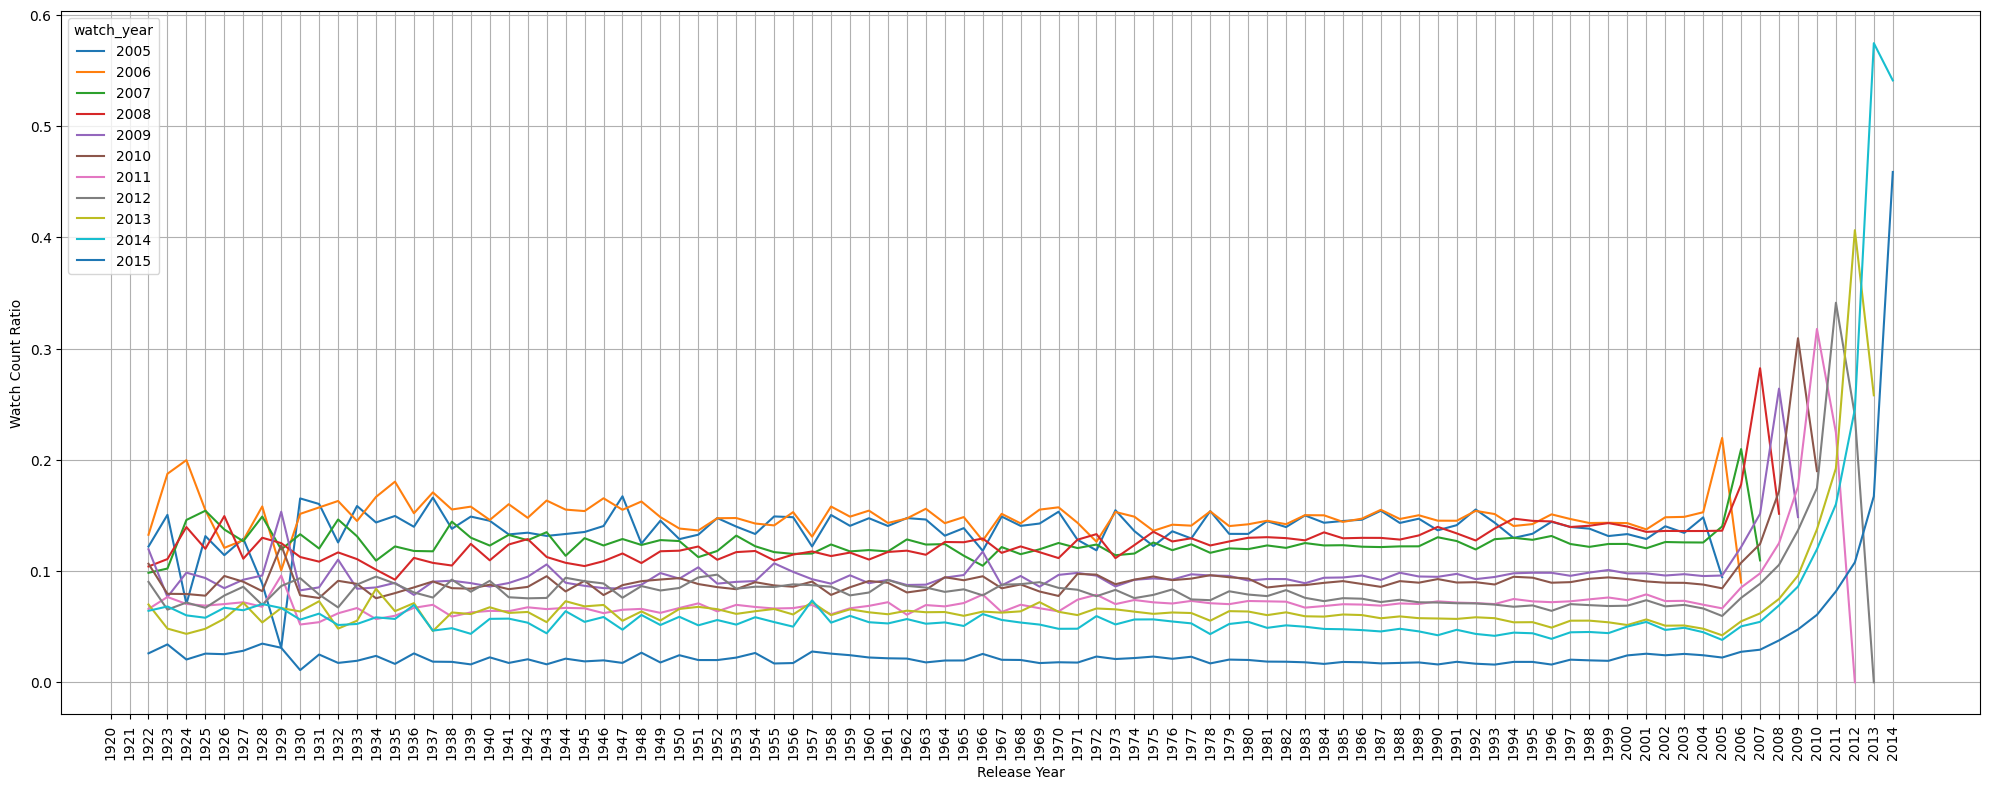

In [37]:
merged_df = pd.merge(train_df, year_data, on='item', how='left')

merged_df['watch_year'] = pd.to_datetime(merged_df['time'], unit='s').dt.year

watch_counts_by_year = merged_df.groupby(['year', 'watch_year']).size().reset_index(name='watch_count')

total_watch_counts_per_release_year = watch_counts_by_year.groupby('year')['watch_count'].sum().reset_index(name='total_watch_count_per_year')

watch_counts_by_year = pd.merge(watch_counts_by_year, total_watch_counts_per_release_year, on='year', how='left')
watch_counts_by_year['watch_count_ratio'] = watch_counts_by_year['watch_count'] / watch_counts_by_year['total_watch_count_per_year']

watch_counts_filtered = watch_counts_by_year[(watch_counts_by_year['year'] >= 1920) & 
                                              (watch_counts_by_year['year'] <= 2014)]

plt.figure(figsize=(20, 8))

sns.lineplot(x='year', y='watch_count_ratio', hue='watch_year', data=watch_counts_filtered, palette='tab10')

plt.xlabel('Release Year')
plt.ylabel('Watch Count Ratio')
plt.xticks(range(1920, 2015), rotation=90)  
plt.grid(True)

plt.tight_layout()
plt.show()

### 2. 연휴/주말 정보 활용

##### 이 데이터셋의 사용자의 국적을 우선적으로 알아야 연휴나 주말을 알 수 있다.

##### 데이터셋 특징
MovieLens 데이터셋은 미국 미네소타 대학의 GroupLens 연구 그룹이 운영하는 MovieLens 웹사이트에서 수집된 영화 평가 데이터를 기반

출처: 미국 미네소타 대학의 GroupLens 연구 그룹.

목적: 영화 추천 시스템 개발 및 연구.

데이터 구성: 사용자들이 영화에 매긴 평점, 영화 정보, 태그, 외부 링크 등 다양한 정보를 포함.


##### 국적 데이터 수집 방법
1. MovieLens 데이터셋 자체가 민감한 개인정보는 공개하지 않음. 따라서 데이터셋에서 국적 정보를 얻기 힘들다. (외부데이터 사용 불가이기도 함)
2. 이 MovieLens 사이트가 어디에 많이 알려져 있는가?: 미국, 영국 등 영어권 나라 -> 이 정보만 가지고 주말/연휴를 특정/추청하기 힘듦


##### 데이터 활용 방안
1. 주말 활용: 각 사용자에 대한 국적 데이터를 알 수 없으므로 사용 불가능. 모든 사용자에 대해 똑같이 적용해야만 가능
2. 연휴 활용: 영어권 나라의 공통된 연휴를 활용?


##### 데이터 사용 방법
1. 주말/연휴 많이 rating을 한 사람은? 이런 장르를 좋아할 것이다.

ex) 연휴에 많이 rating을 한 사용자가 있다면? 어떤 장르를 특히/주로 rating을 하는지 파악 가능? -> 불분명 할 것이라고 추측됨. 또한 "많이"의 기준이 무엇인가

<br>

결론: 어렵다.